In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from scipy.ndimage import median_filter

In [11]:
# Functions to compute alpha and beta
def get_alpha(u, P):
    if u == 1:
        return np.sqrt(1/P)
    else:
        return np.sqrt(2/P)

def get_beta(v, Q):
    if v == 1:
        return np.sqrt(1/Q)
    else:
        return np.sqrt(2/Q)

In [12]:
# Function to get the basis chip
def get_basis_chip(u, v, P=8, Q=8):
    
    # Compute alpha and beta
    a_u = get_alpha(u, P)
    b_v = get_beta(v, Q)
    
    # Create empty basis chip
    basis_chip = np.zeros((P, Q))
    
    # Calculate the basis chip
    for x in range(1, P+1):
        for y in range(1, Q+1):
            basis_chip[y-1, x-1] = a_u * b_v * np.cos(np.pi * (2 * x - 1) * (u - 1) / (2 * P)) * np.cos(np.pi * (2 * y - 1) * (v - 1) / (2 * Q))
    
    # Return the basis chip with the right orientation
    return basis_chip

In [13]:
# Function to calculate convert basis chip into basis vector
def get_basis_vector_matrix(K=8):
    num_basis_vectors = K**2
    
    # Initialize the 64x64 basis vector matrix
    basis_vector_matrix = np.zeros((num_basis_vectors, num_basis_vectors))
    
    # Get all basis chips and rasterize them into column vectors
    index = 0
    for u in range(1, K + 1):
        for v in range(1, K + 1):
            # Get the basis chip
            basis_chip = get_basis_chip(u, v, P=K, Q=K)
            
            # Rasterize the basis chip into a column vector
            basis_vector_matrix[:, index] = basis_chip.flatten(order='F')
            index += 1

    return basis_vector_matrix

In [14]:
# Generate the 8x8 corrupted image block (chip)
def generate_corrupted(S=30, block_size=8, block=None):
    # Generate the mask
    total_pixels = block_size * block_size
    indices = np.random.choice(total_pixels, S, replace=False)
    
    # Normalize the grayscale block to the range 0–255
    block_normalized = (block - block.min()) / (block.max() - block.min()) * 255
    block_normalized = block_normalized.astype(np.uint8)

    # Generate a mask and set missing pixel intensities to NaN
    mask = np.zeros((block_size, block_size), dtype=bool)
    for index in indices:
        row, col = divmod(index, block_size)
        mask[row, col] = True
    
    # Sets corrupted pixels to NaN
    nan_block = block.astype(float)
    nan_block[~mask] = np.nan
    
    return nan_block, mask
    

In [15]:
def apply_lasso_reconstruction(B, block, mask, alpha):
    # Flatten block and mask
    C = block.flatten(order='F')
    sampling_mask = mask.flatten(order='F')

    # Create A and D matrices
    D = C[sampling_mask]
    A = B[sampling_mask, :]

    # Apply LASSO regression
    lasso = Lasso(alpha=alpha, fit_intercept=True)
    lasso.fit(A, D)
    kappa_est = lasso.coef_
    intercept = lasso.intercept_

    # Reconstruct image chip
    C_hat = B @ kappa_est + intercept
    C_hat = C_hat.reshape(8, 8, order='F')

    return C_hat, kappa_est


In [16]:
def generate_corrupted_image(image_array, S, block_size=8):
    height, width = image_array.shape
    corrupted_image = image_array.astype(float).copy()

    # Process each block independently
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = image_array[i:i+block_size, j:j+block_size]
            
            # Check if block is full size (edge cases for non-multiple sizes)
            if block.shape[0] == block_size and block.shape[1] == block_size:
                corrupted_block, _ = generate_corrupted(S, block_size, block)
                corrupted_image[i:i+block_size, j:j+block_size] = corrupted_block

    return corrupted_image

In [17]:
def calculate_mse(original, reconstructed):
    mask = ~np.isnan(original)
    return mean_squared_error(original[mask], reconstructed[mask])

In [18]:
def image_reconstruction(image_array, corrupted_image, block_size=8, alpha=None, B=None, S=None):
    # Initialize the reconstructed image
    height, width = image_array.shape
    reconstructed_image = np.zeros_like(image_array, dtype=float)
    
    # Reconstruct each block in the image
    for i in range(0, height, block_size):
        for j in range(0, width, block_size):
            block = corrupted_image[i:i+block_size, j:j+block_size]
            mask = ~np.isnan(block)
            
            if np.sum(mask) > 0:  # Ensure there are valid pixels
                reconstructed_block, _ = apply_lasso_reconstruction(B, block, mask, alpha)
                reconstructed_image[i:i+block_size, j:j+block_size] = reconstructed_block
                
    # Apply median filtering to the reconstructed image
    reconstructed_image_filtered = median_filter(reconstructed_image, size=3)
    
    mse_before = calculate_mse(image_array, reconstructed_image)
    mse_after = calculate_mse(image_array, reconstructed_image_filtered)
    
    # Plot the images
    fig, axes = plt.subplots(1, 3, figsize=(20, 5))
    axes[0].imshow(corrupted_image, cmap='gray')
    axes[0].set_title("Corrupted Image")
    axes[0].axis("off")

    axes[1].imshow(reconstructed_image, cmap='gray')
    axes[1].set_title("Reconstructed Image (No Filtering) with S = {}".format(S))
    axes[1].axis("off")

    axes[2].imshow(reconstructed_image_filtered, cmap='gray')
    axes[2].set_title("Reconstructed Image (With Median Filtering) with S = {}".format(S))
    axes[2].axis("off")
    
    plt.show()
    
    return mse_before, mse_after

In [19]:
# Load image
image_path = '../data/fishing_boat.bmp'
image = Image.open(image_path).convert('L')

# Convert the image to a numpy array
image_array = np.array(image)

In [20]:
# Display the 8x8 block with the top-left pixel at (x, y) = (x*, y*)
x_star = 8 * (4-1) + 1
y_star = 8 * (2-1) + 1

# Get the 8x8 block
block_size = 8
x_start = x_star - 1
y_start = y_star - 1

# Get the block end coordinates
x_end = min(x_start + block_size, image_array.shape[0])
y_end = min(y_start + block_size, image_array.shape[1])

# Gets the 8x8 block
block = image_array[y_start:y_end, x_start:x_end]

/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.886e+00, tolerance: 1.945e+00
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.551e-01, tolerance: 8.809e-02
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

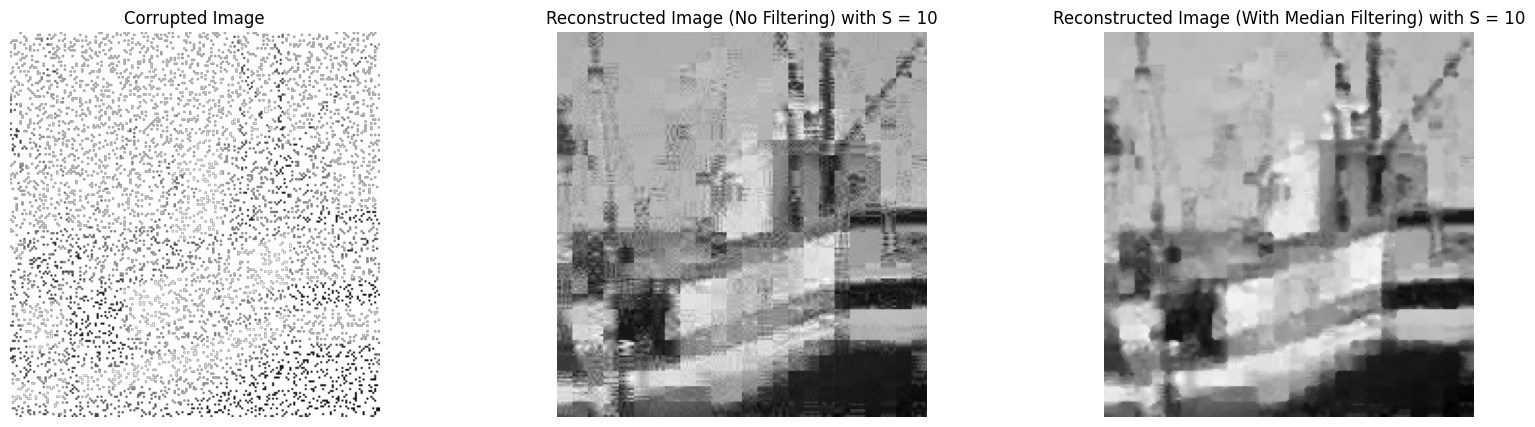

/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.287e-01, tolerance: 9.812e-02
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.024e-02, tolerance: 9.695e-03
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

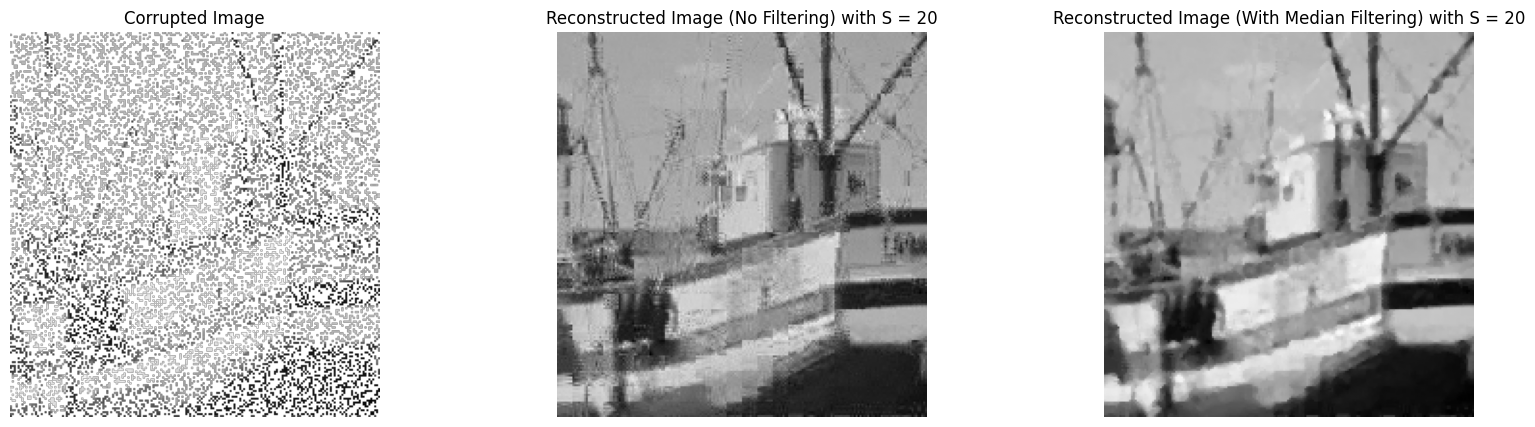

/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.376e-01, tolerance: 1.370e-01
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.298e+01, tolerance: 1.107e+01
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

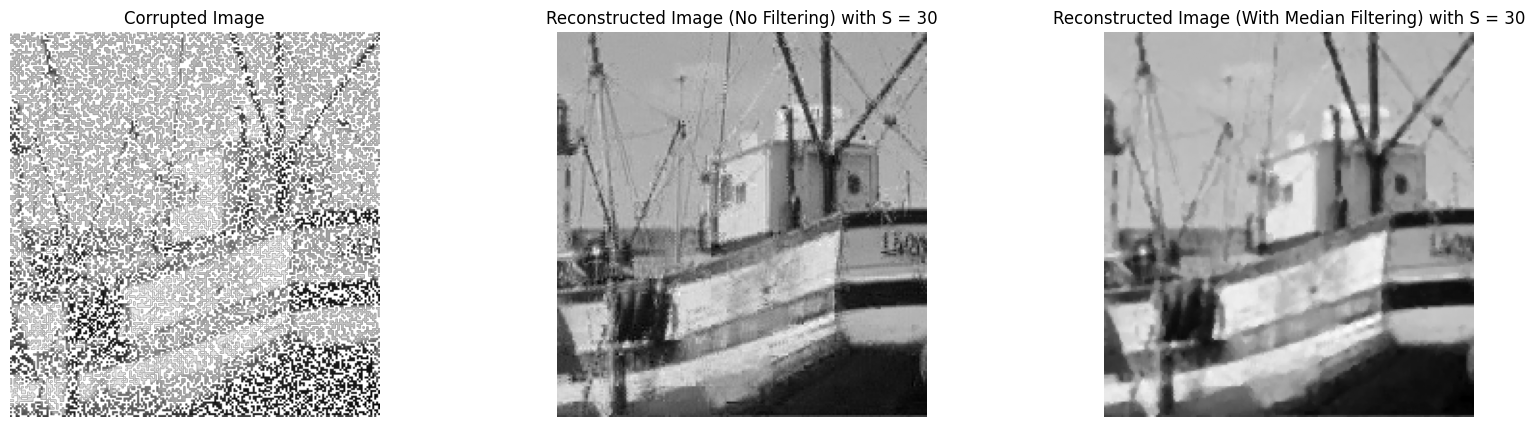

/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.081e+01, tolerance: 9.682e+00
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.128e+00, tolerance: 6.744e+00
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

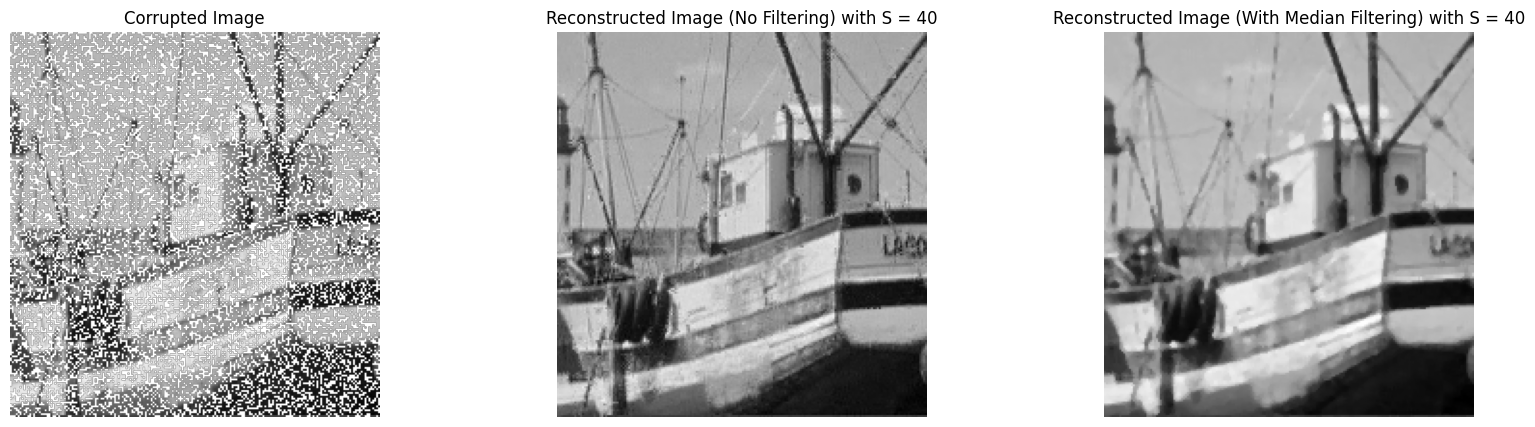

/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.323e-01, tolerance: 7.469e-01
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.007e+00, tolerance: 9.617e-01
  model = cd_fast.enet_coordinate_descent(
/home/ren11/image-recovery/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider in

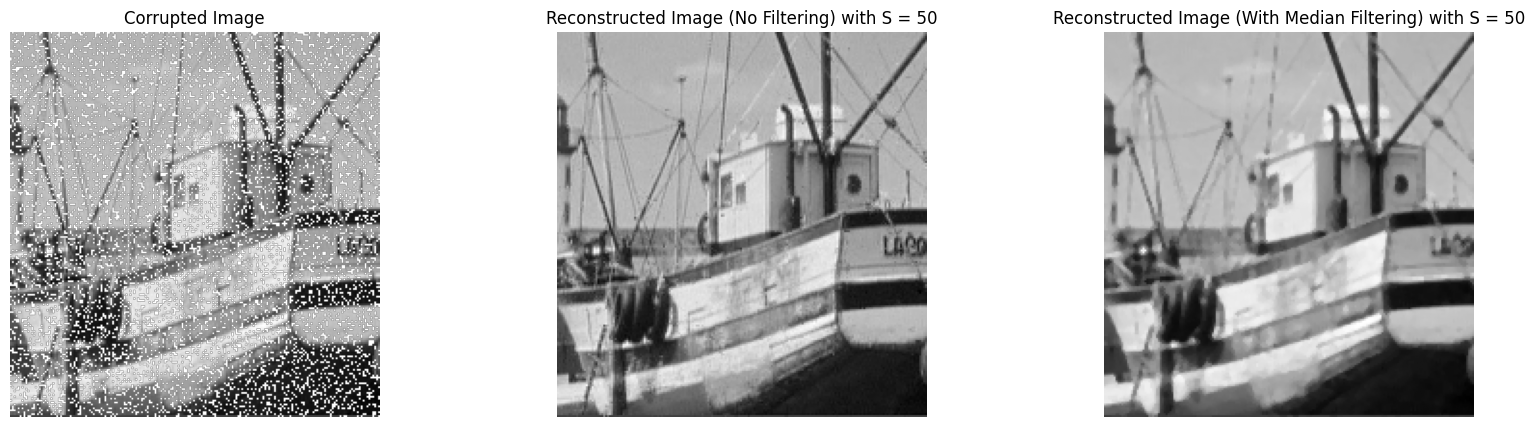

In [21]:
# Optimal alpha value
alpha = 3e-3

# S values
S_values = [10, 20, 30, 40, 50]

# Get the vector matrix
B = get_basis_vector_matrix(K=8)

mse_before_filtering = []
mse_after_filtering = []

for S in S_values:
    # Generate corrupted block
    corrupted_block, mask = generate_corrupted(S, block_size=8, block=block)

    # Generate corrupted image
    corrupted_image = generate_corrupted_image(image_array, S)

    # Reconstruct image
    mse_before, mse_after = image_reconstruction(image_array, corrupted_image, alpha=alpha, B=B, S=S)
    
    mse_before_filtering.append(mse_before)
    mse_after_filtering.append(mse_after)

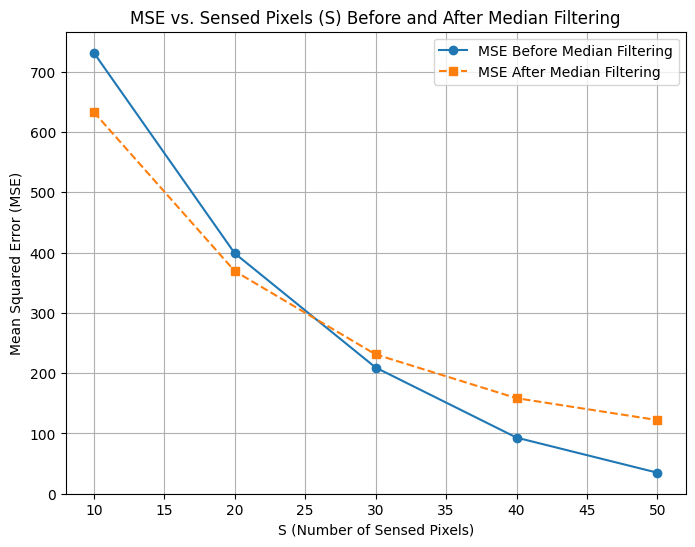

In [22]:
# Plot MSE vs. S
plt.figure(figsize=(8, 6))
plt.plot(S_values, mse_before_filtering, marker='o', linestyle='-', label='MSE Before Median Filtering')
plt.plot(S_values, mse_after_filtering, marker='s', linestyle='--', label='MSE After Median Filtering')

plt.xlabel("S (Number of Sensed Pixels)")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("MSE vs. Sensed Pixels (S) Before and After Median Filtering")
plt.legend()
plt.grid()
plt.show()